1. [Defining the problem](#section1)
2. [Collecting the data](#section2)
3. [Data exploration](#section3)
4. [Feature engineering](#section4)
5. [Modelling](#section5)
6. [Testing](#section6)

# <a name="section1">1. Defining the problem</a>

Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

# <a name="section2">2. Collecting the data</a>


In [141]:
import pandas as pd
import numpy as np

train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [142]:
def get_combined_data(train_df, test_df):
    # deep copying the datasets to not change the originals
    train_df = train_df.copy()
    test_df = test_df.copy()
    # removing the targets from the training data 
    train_df.drop(['Survived'], axis=1, inplace=True)
    
    # merging train data and test data for future feature engineering
    # we'll also remove the PassengerID since this is not an informative feature
    combined = pd.concat([train_df, test_df])
    combined.drop(['PassengerId'], inplace=True, axis=1)
    
    return combined

combined = get_combined_data(train_df=train, test_df=test)
train_test_data = [train, test]

# <a name="section3">3. Data exploration</a>

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

In [144]:
print(train.head())
print(test.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [145]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [146]:
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


### Bar charts for categorical features

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

In [148]:
def bar_chart(feature):
    survived = train[train['Survived']==1][feature].value_counts()
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

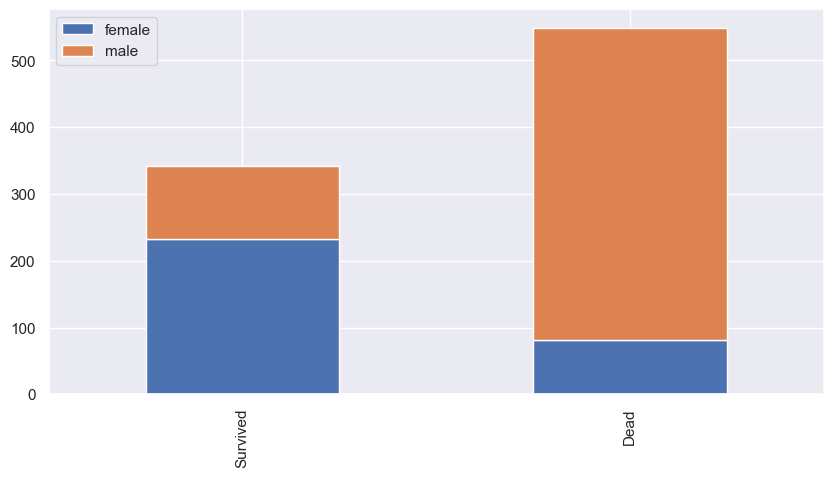

In [149]:
bar_chart('Sex')

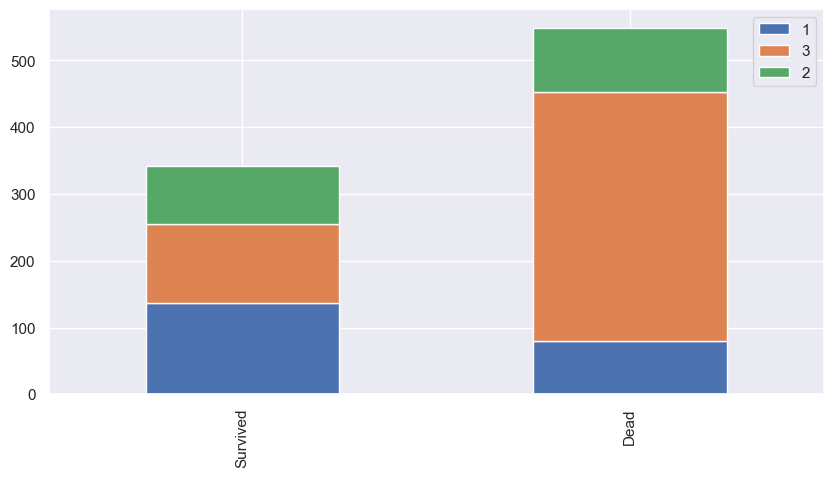

In [150]:
bar_chart('Pclass')

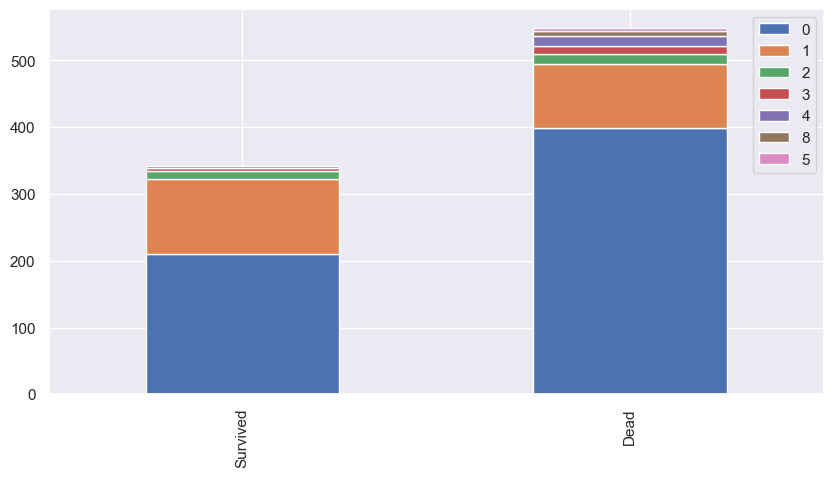

In [151]:
bar_chart('SibSp')

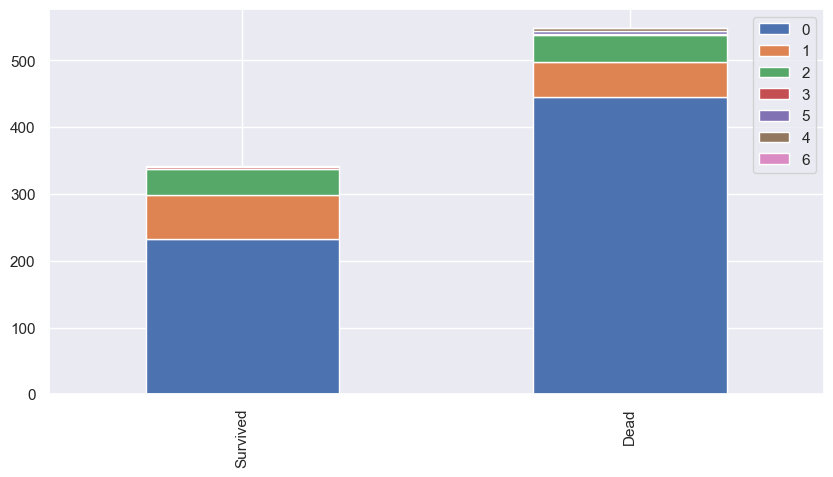

In [152]:
bar_chart('Parch')

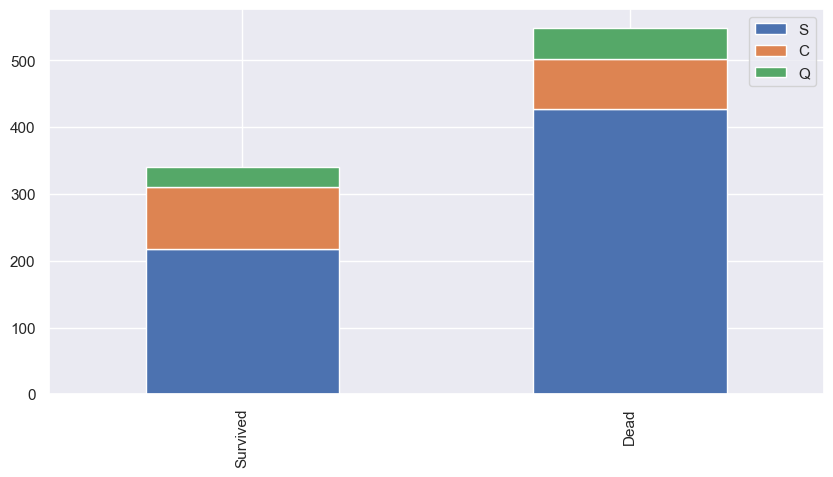

In [153]:
bar_chart('Embarked')

# <a name="section4">4. Feature engineering</a>

## Name

Lets see the titles (Mr, Mrs, etc) present in each of our datasets:

In [154]:
titles_train = set()
for name in train['Name']:
    titles_train.add(name.split(',')[1].split('.')[0].strip())
    
titles_test =set()
for name in test['Name']:
    titles_test.add(name.split(',')[1].split('.')[0].strip())  
# values present in train but not test    
values_in_titles_train_only = titles_train.difference(titles_test)
print(values_in_titles_train_only)
# values present in test but not train
values_in_titles_test_only = titles_test.difference(titles_train)
print(values_in_titles_test_only)
# values present in only one dataframe (doesn't matter wich one)
values_in_one_set_only = titles_train.symmetric_difference(titles_test)
print(values_in_one_set_only)

{'Major', 'Jonkheer', 'Lady', 'Sir', 'Mme', 'Capt', 'Don', 'the Countess', 'Mlle'}
{'Dona'}
{'Major', 'Jonkheer', 'Lady', 'Mlle', 'Sir', 'Mme', 'Capt', 'Don', 'the Countess', 'Dona'}


Lets extract the titles and map them to the new column 'Title'

In [155]:
combined['Title'] = combined['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())

In [156]:
# frequency of all Titles
combined['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

Mr, Miss and Mrs are the most frequent titles. For the remaining ones, we are going to map the value 'Other' to them

In [157]:
def map_values(x):
    values_list= ['Mr', 'Miss', 'Mrs']
    if x in values_list:
        return x
    else:
        return 'Other'

combined['Title'] = combined['Title'].map(map_values)
for dataset in train_test_data:
    dataset['Title']= dataset['Title'].map(map_values)

In [158]:
combined['Title'].value_counts()

Mr       757
Miss     260
Mrs      197
Other     95
Name: Title, dtype: int64

And we are going to remove the 'Name' column because we have created 'Title'

In [159]:
combined.drop('Name', axis=1, inplace=True)
for dataset in train_test_data:
    dataset.drop('Name', axis=1, inplace=True)

## Age

Fill missing age with Title's median age

In [160]:
df=combined[combined['Age'].isnull()]
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Other'], dtype=object)

In [161]:
grouped_combined = combined.groupby('Title')
grouped_median_combined = grouped_combined.median()
grouped_median_combined = grouped_median_combined.reset_index()[['Title', 'Age']]

grouped_median_combined.head()

,Title,Age
0,Miss,22.0
1,Mr,29.0
2,Mrs,35.5
3,Other,9.0


In [162]:
def fill_age(row):
    condition = (grouped_median_combined['Title'] == row['Title']) 
    return grouped_median_combined[condition]['Age'].iloc[0]


def process_age():
    global combined
    # a function that fills the missing values of the Age variable
    combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return combined

combined = process_age()

In [163]:
combined.isnull().sum()

Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
Title          0
dtype: int64

In [164]:
for dataset in train_test_data:
    dataset['Age'] = dataset.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)

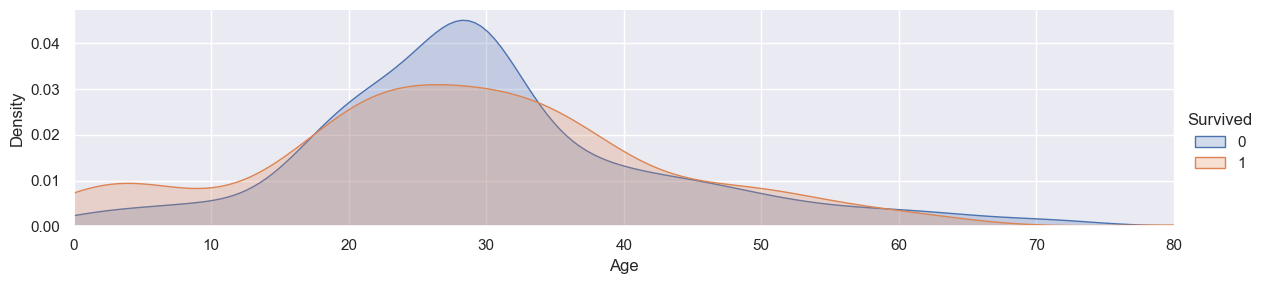

In [165]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age', fill= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
 
plt.show() 

## Fare

In [166]:
mean_fare = combined['Fare'].mean()

combined['Fare'].fillna(mean_fare, inplace=True)
for dataset in train_test_data:
    dataset['Fare'].fillna(mean_fare, inplace=True)

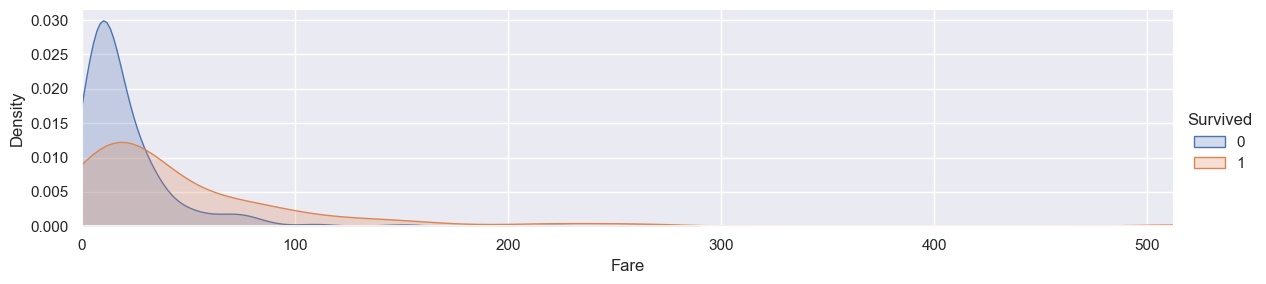

In [167]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',fill= True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()
 
plt.show() 

In [168]:
combined['Fare'].min(), combined['Fare'].max()

(0.0, 512.3292)

In [169]:
q1 = combined['Fare'].quantile(0.25)
print(q1)
q2 = combined['Fare'].quantile(0.50)
print(q2)
q3 = combined['Fare'].quantile(0.75)
print(q3)

7.8958
14.4542
31.275


In [170]:
combined.loc[ combined['Fare'] <= q1, 'Fare'] = 0
combined.loc[(combined['Fare'] > q1) & (combined['Fare'] <= q2), 'Fare'] = 1
combined.loc[(combined['Fare'] > q2) & (combined['Fare'] <= q3), 'Fare'] = 2
combined.loc[ combined['Fare'] > q3, 'Fare'] = 3

for dataset in train_test_data:
    dataset.loc[ dataset['Fare'] <= q1, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > q1) & (dataset['Fare'] <= q2), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > q2) & (dataset['Fare'] <= q3), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > q3, 'Fare'] = 3

## Embarked

In [171]:
combined.isnull().sum()

Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin       1014
Embarked       2
Title          0
dtype: int64

The missing ports of Embarkation belong to passangers that go on 1st class

In [172]:
combined[combined['Embarked'].isnull()]['Pclass']

61     1
829    1
Name: Pclass, dtype: int64

<AxesSubplot:>

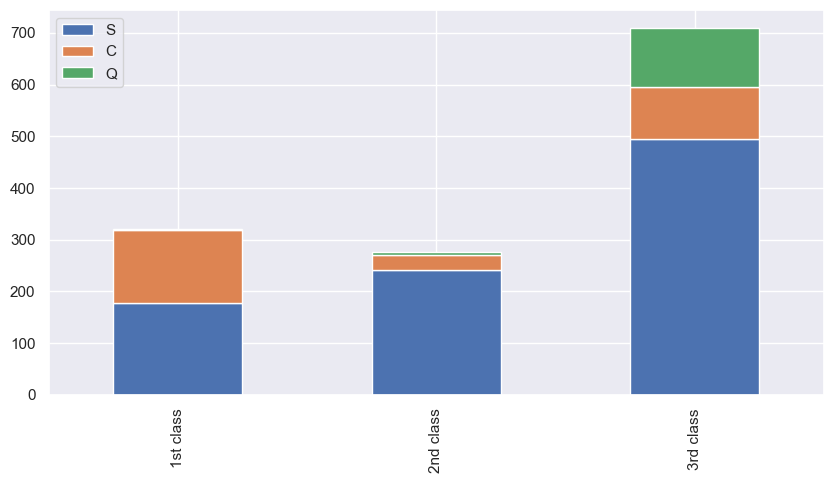

In [173]:
Pclass1 = combined[combined['Pclass']==1]['Embarked'].value_counts()
Pclass2 = combined[combined['Pclass']==2]['Embarked'].value_counts()
Pclass3 = combined[combined['Pclass']==3]['Embarked'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5))

We set the misssing embarkation ports to 'S' because is the most prevalent Port of embarkation for 1st class passengers.

In [174]:
combined['Embarked'].fillna('S', inplace=True)
for dataset in train_test_data:
    dataset['Embarked'].fillna('S', inplace=True)

## FamilySize

In [175]:
combined["FamilySize"] = combined["SibSp"] + combined["Parch"] + 1
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

(0.0, 11.0)

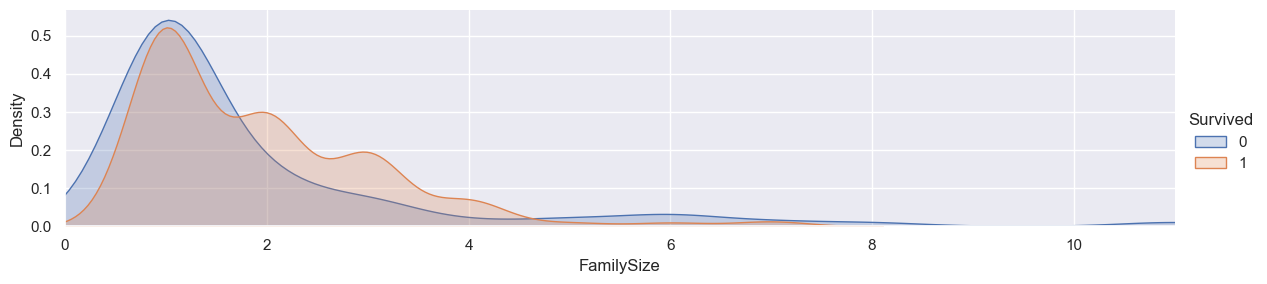

In [176]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'FamilySize',fill= True)
facet.set(xlim=(0, train['FamilySize'].max()))
facet.add_legend()
plt.xlim(0)

And we are going to remove the 'SibSp' and 'Parch' columns because we have created 'FamilySize'

In [177]:
combined.drop(['SibSp','Parch'], axis=1, inplace=True)
for dataset in train_test_data:
    dataset.drop(['SibSp','Parch'], axis=1, inplace=True)

## Ticket

We are going to remove the 'Ticket' column

In [178]:
combined.drop('Ticket', axis=1, inplace=True)
for dataset in train_test_data:
    dataset.drop('Ticket', axis=1, inplace=True)

## Cabin

In [179]:
combined.Cabin.value_counts()

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F33                4
                  ..
A14                1
E63                1
E12                1
E38                1
C105               1
Name: Cabin, Length: 186, dtype: int64

In [180]:
combined['Cabin'] = combined['Cabin'].str[:1]
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]

There is no 'T' cabin in test data

In [181]:
print(train['Cabin'].unique())
print(test['Cabin'].unique())

[nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
[nan 'B' 'E' 'A' 'C' 'D' 'F' 'G']


Because there is no 'T' value for Cabin in the test data, we will have to add a dummy column that encodes the 'T' later, once we do the dummy encoding of the 'Cabin' feature. We are doing this to avoid a difference in number of columns for the test and train data that could cause problems in the modelling part later on.

<AxesSubplot:>

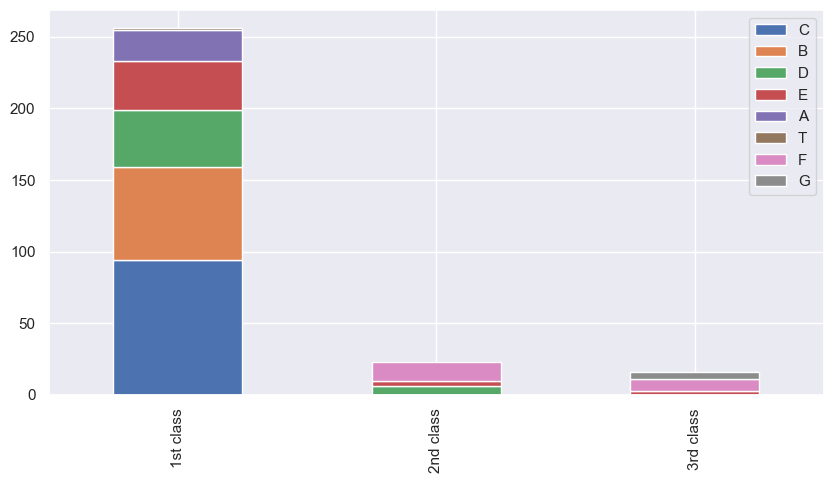

In [182]:
Pclass1 = combined[combined['Pclass']==1]['Cabin'].value_counts()
Pclass2 = combined[combined['Pclass']==2]['Cabin'].value_counts()
Pclass3 = combined[combined['Pclass']==3]['Cabin'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5))

<AxesSubplot:>

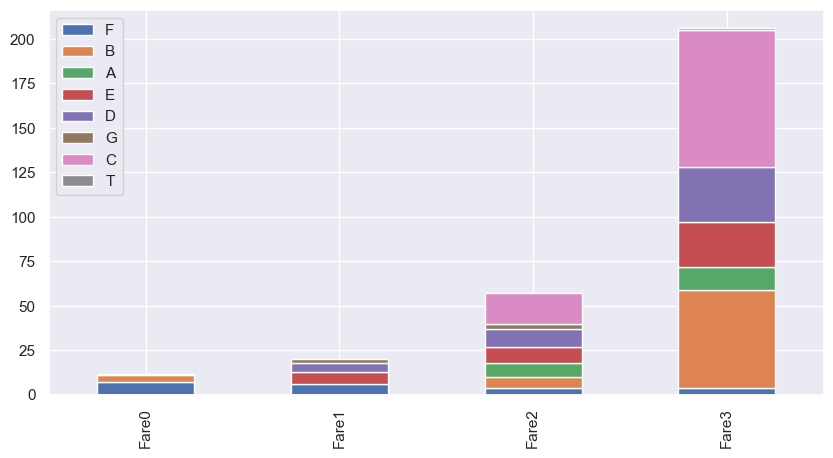

In [183]:
Fare0 = combined[combined['Fare']==0]['Cabin'].value_counts()
Fare1 = combined[combined['Fare']==1]['Cabin'].value_counts()
Fare2 = combined[combined['Fare']==2]['Cabin'].value_counts()
Fare3 = combined[combined['Fare']==3]['Cabin'].value_counts()
df = pd.DataFrame([Fare0, Fare1, Fare2, Fare3])
df.index = ['Fare0','Fare1','Fare2', 'Fare3']
df.plot(kind='bar',stacked=True, figsize=(10,5))

<AxesSubplot:>

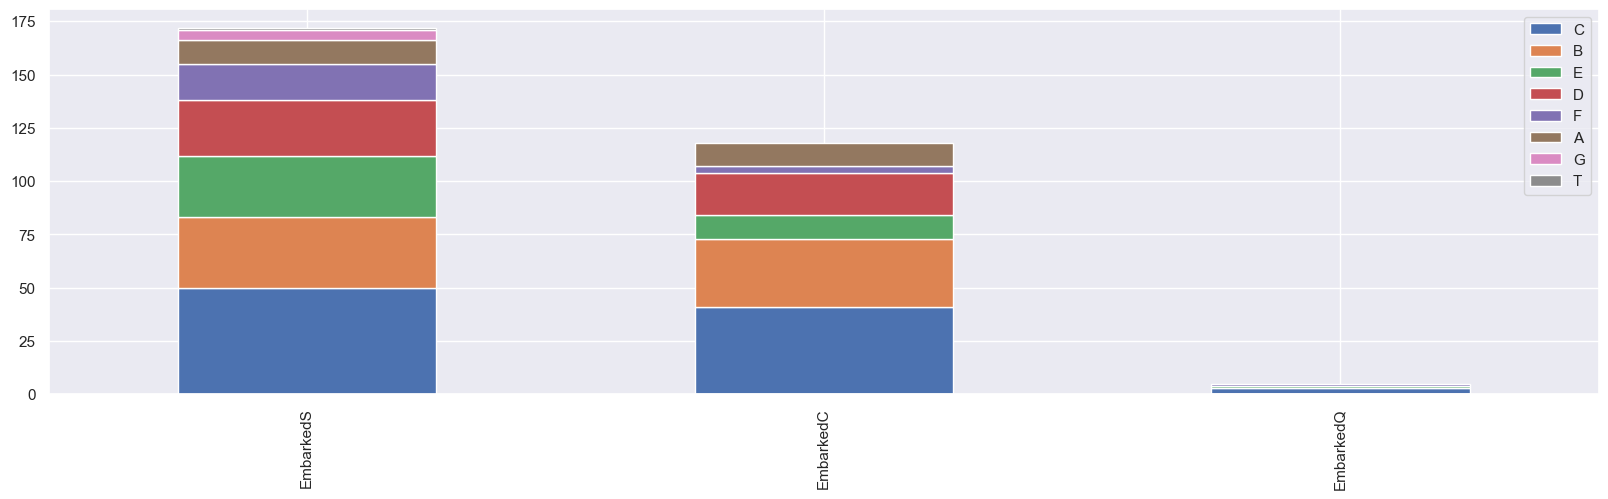

In [184]:
EmbarkedS = combined[combined['Embarked']=='S']['Cabin'].value_counts()
EmbarkedC = combined[combined['Embarked']=='C']['Cabin'].value_counts()
EmbarkedQ = combined[combined['Embarked']=='Q']['Cabin'].value_counts()
df = pd.DataFrame([EmbarkedS, EmbarkedC, EmbarkedQ])
df.index = ['EmbarkedS','EmbarkedC','EmbarkedQ']
df.plot(kind='bar',stacked=True, figsize=(20,5))

<AxesSubplot:>

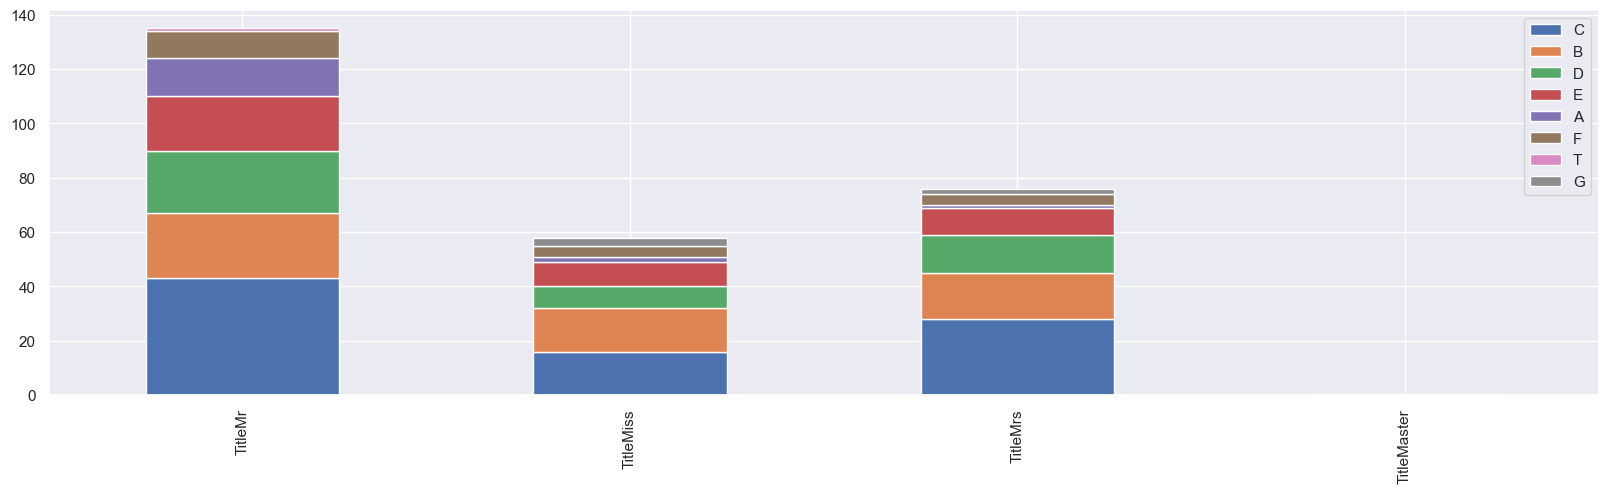

In [185]:
TitleMr = combined[combined['Title']=='Mr']['Cabin'].value_counts()
TitleMiss = combined[combined['Title']=='Miss']['Cabin'].value_counts()
TitleMrs = combined[combined['Title']=='Mrs']['Cabin'].value_counts()
TitleMaster = combined[combined['Title']=='Master']['Cabin'].value_counts()
df = pd.DataFrame([TitleMr, TitleMiss, TitleMrs, TitleMaster])
df.index = ['TitleMr','TitleMiss','TitleMrs', 'TitleMaster']
df.plot(kind='bar',stacked=True, figsize=(20,5))

<AxesSubplot:xlabel='FamilySize'>

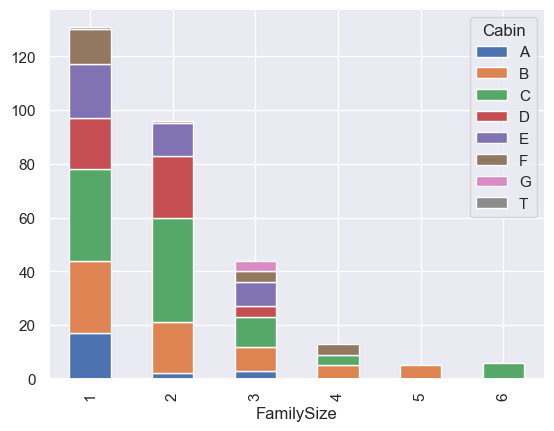

In [186]:
grouped = combined.groupby('FamilySize')['Cabin'].value_counts()

grouped.unstack().plot.bar(stacked=True)

In [187]:
combined.groupby(['Pclass', 'Fare'])['Cabin'].apply(lambda x: x.value_counts())


Pclass  Fare   
1       0.0   B     4
              A     1
        2.0   C    17
              D     9
              E     9
              A     8
              B     6
        3.0   C    77
              B    55
              D    31
              E    25
              A    13
              T     1
2       1.0   F     6
              D     5
              E     4
        2.0   F     3
              D     1
        3.0   F     4
3       0.0   F     7
        1.0   E     3
              G     2
        2.0   G     3
              F     1
Name: Cabin, dtype: int64

Replacing the NaN values of 'Cabin' with U (for Unknown)

In [188]:
# replacing missing cabins with U (for Uknown)
combined['Cabin'].fillna('U', inplace=True)
for dataset in train_test_data:
    dataset['Cabin'].fillna('U', inplace=True)

In [189]:
combined.isnull().sum()

Pclass        0
Sex           0
Age           0
Fare          0
Cabin         0
Embarked      0
Title         0
FamilySize    0
dtype: int64

## Dummy variable encoding

Now we are going to one-hot encode (or encode in dummy variables) the categorical columns of the train and test dataframes.

In [190]:
columns_to_dummies = ['Title', 'Embarked', 'Cabin', 'Pclass','Sex']
train = pd.get_dummies(train, columns=columns_to_dummies)
test = pd.get_dummies(test, columns=columns_to_dummies)

In [191]:
print(train.columns)
print(test.columns)

Index(['PassengerId', 'Survived', 'Age', 'Fare', 'FamilySize', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Other', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male'],
      dtype='object')
Index(['PassengerId', 'Age', 'Fare', 'FamilySize', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Other', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_U', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male'],
      dtype='object')


As mention before, lets add the 'CabinT' dummy column that is only present in the the train data to the test data as well with its values set to 0

In [192]:
# insert a  dummy column 'Cabin_T' after dummy column 'Cabin_G' in test dataframe with all values 0
col_Cabin_G_index = test.columns.get_loc('Cabin_G')
test.insert(loc=col_Cabin_G_index+1, column='Cabin_T', value=0, allow_duplicates=True)

In [193]:
train.head()

,PassengerId,Survived,Age,Fare,FamilySize,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Embarked_C,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,1,0,22.0,0.0,2,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,1
1,2,1,38.0,3.0,2,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1,0
2,3,1,26.0,1.0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
3,4,1,35.0,3.0,2,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,5,0,35.0,1.0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,1


In [194]:
test.isnull().sum()

PassengerId    0
Age            0
Fare           0
FamilySize     0
Title_Miss     0
Title_Mr       0
Title_Mrs      0
Title_Other    0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Cabin_A        0
Cabin_B        0
Cabin_C        0
Cabin_D        0
Cabin_E        0
Cabin_F        0
Cabin_G        0
Cabin_T        0
Cabin_U        0
Pclass_1       0
Pclass_2       0
Pclass_3       0
Sex_female     0
Sex_male       0
dtype: int64

# <a name="section5">5. Modelling</a>

First lets do some final preparations of data to start modelling

In [195]:
# Remove the 'Survived' column since is not part of the input features for training the model
train_data = train.drop(['Survived', 'PassengerId'], axis=1).copy()
# extract the target variable
target = train['Survived']
train_data.shape, target.shape

((891, 24), (891,))

In [196]:
# Importing Classifier Modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import numpy as np

## Cross validation (K-fold)

In [197]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## KNN

In [198]:
import warnings

# Suppress warning message
warnings.filterwarnings("ignore")

clf = KNeighborsClassifier(n_neighbors = 13)
scoring = 'accuracy' # if a model makes 100 predictions and 80 are correct, the model's accuracy is 0.8 (80/100)
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.74444444 0.83146067 0.71910112 0.70786517 0.78651685 0.7752809
 0.84269663 0.82022472 0.7752809  0.83146067]


In [199]:
# kNN Score
round(np.mean(score)*100, 2)

78.34

## Decision Tree

In [200]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.74444444 0.83146067 0.74157303 0.80898876 0.84269663 0.84269663
 0.80898876 0.7752809  0.78651685 0.79775281]


In [201]:
# decision tree Score
round(np.mean(score)*100, 2)

79.8

## Ramdom Forest

In [202]:
clf = RandomForestClassifier(n_estimators=20)
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.77777778 0.87640449 0.78651685 0.82022472 0.85393258 0.82022472
 0.85393258 0.78651685 0.79775281 0.83146067]


In [203]:
# Random Forest Score
round(np.mean(score)*100, 2)

82.05

## Gaussian Naive Bayes

In [204]:
clf = GaussianNB()
scoring = 'accuracy' 
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.83333333 0.70786517 0.73033708 0.71910112 0.69662921 0.76404494
 0.78651685 0.7752809  0.82022472 0.83146067]


In [205]:
# Naive Bayes Score
round(np.mean(score)*100, 2)

76.65

## Support Vector Machines (SVM)

In [206]:
clf = SVC()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.71111111 0.79775281 0.75280899 0.6741573  0.83146067 0.76404494
 0.71910112 0.75280899 0.68539326 0.66292135]


In [207]:
round(np.mean(score)*100,2)

73.52

We keep the Random Forest model as the one for making predictions

# <a name="section6">6. Testing</a>

In [208]:
clf = RandomForestClassifier(n_estimators=20)
clf.fit(train_data, target)

test_data = test.drop("PassengerId", axis=1).copy()
prediction = clf.predict(test_data)

In [209]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": prediction
    })

submission.to_csv('submission.csv', index=False)

In [210]:
submission = pd.read_csv('submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
